In [1]:
import librosa.display
import librosa.util
from IPython.display import Audio
import os
import scipy
from scipy.io import wavfile
import numpy as np
import utils.synthesis_util as su
import utils.model_util as mu
from utils.metrics import Metrics
from pesq_lib.pypesq import pypesq

## Examine dataset

In [2]:
audio_files = su.load_files()
id_audio=2386

### Clean audio

In [3]:
y_clean,sr = su.get_audio(audio_id=id_audio,audio_files=audio_files)
Audio(y_clean,rate=sr)

## Noisy audio

In [4]:
y_noise, sr = su.get_noisy_audio(audio_id=id_audio,audio_files=audio_files, noise_factor=0.05)
Audio(y_noise,rate=sr)

In [5]:
win = scipy.signal.hamming(256,"periodic")
magnitude,phase = su.audio_to_sttft(y_noise,win)

In [6]:
predictors = su.get_predictors(magnitude)

In [7]:
predictors = np.array(predictors)
predictors.shape

(306, 129, 8)

## Load module

In [8]:
model = mu.load_model(n_features=129,n_segments=8,model_to_test="Baseline_Convolutional/0520_170646", type='conv_deep')

## Denoise

In [9]:
length = len(y_noise)

In [10]:
sample = su.obtain_sample(predictors)

In [11]:
# print(model)
audio_rec = su.denoise_audio(model,sample,phase,win,length, type ='conv')
print(audio_rec.shape)
Audio(audio_rec,rate=sr)

(19867,)


### Visualize spectrograms

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


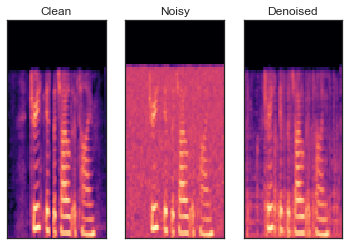

In [13]:
plt.subplot(1,3,1)
S = librosa.feature.melspectrogram(y=y_clean,
                                   sr=sr,
                                   n_fft=1024,
                                   hop_length=256,
                                   n_mels=80,
                                   fmin=125,
                                   fmax=7600)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
plt.title("Clean")

plt.subplot(1,3,2)
S = librosa.feature.melspectrogram(y=y_noise,
                                   sr=sr,
                                   n_fft=1024,
                                   hop_length=256,
                                   n_mels=80,
                                   fmin=125,
                                   fmax=7600)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
plt.title("Noisy")

plt.subplot(1,3,3)
S = librosa.feature.melspectrogram(y=audio_rec,
                                   sr=sr,
                                   n_fft=1024,
                                   hop_length=256,
                                   n_mels=80,
                                   fmin=125,
                                   fmax=7600)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
plt.title("Denoised")
plt.show()


# Calculate metrics

In [14]:
magnitude_clean,phase_clean = su.audio_to_sttft(y_clean,win)
magnitude_noise,phase_noise = su.audio_to_sttft(y_noise,win)
magnitude_denoised,phase_denoised = su.audio_to_sttft(audio_rec,win)
print(f"SNR_db for clean: {10*np.log10(Metrics.DER_SNR(Metrics.spectral_flux(magnitude_clean, sr)))}")
print(f"SNR_db for noise: {10*np.log10(Metrics.DER_SNR(Metrics.spectral_flux(magnitude_noise, sr)))}")
print(f"SNR_db for denoised: {10*np.log10(Metrics.DER_SNR(Metrics.spectral_flux(magnitude_denoised, sr)))}")


SNR_db for clean: 27.701396784147008
SNR_db for noise: 25.960845193493554
SNR_db for denoised: 30.191262790624165


In [15]:
print(sr)

8000.0


In [16]:
print(f"PESQ value with narrowband (nb) considering original signal and original+noise: {pypesq(sr, y_clean, y_noise, 'nb')}")
print(f"PESQ value with narrowband (nb) considering original signal and reconstructed signal: {pypesq(sr, y_clean, audio_rec, 'nb')}")

PESQ value with narrowband (nb) considering original signal and original+noise: 1.71514892578125
PESQ value with narrowband (nb) considering original signal and reconstructed signal: 1.729668140411377


### Aggregated metrics

In [17]:
trainset_indices = su.get_trainset_indices()
print(trainset_indices)
testset_inidices = su.get_testset_inidces()
print(testset_inidices)

[4438, 5752, 4174, 3387, 528, 7779, 5787, 6048, 7511, 3785]
[8285, 8195, 8243, 8199, 8266, 8289, 8223, 8250, 8208, 8232]


In [19]:
Metrics.aggregate_metric_check(audio_files, model, indices=trainset_indices)

Computing... 0.0%


{'snr': {'clean': (30.732718249202275, 3.7775283910811743),
  'noise': (31.88947778846032, 3.5005308021101222),
  'denoised': (34.232018263760004, 2.2768297874725083)},
 'pesq': {'clean': (4.548638343811035, 0.0),
  'noise': (1.5521208763122558, 0.11614163210197301),
  'denoised': (1.578145170211792, 0.1049659742601875)}}

In [20]:
Metrics.aggregate_metric_check(audio_files, model, indices=testset_inidices)

Computing... 0.0%


{'snr': {'clean': (29.689019184882632, 3.735320294719083),
  'noise': (30.84007590629052, 3.065715338807655),
  'denoised': (31.725161505929492, 2.27832481137159)},
 'pesq': {'clean': (4.548638343811035, 0.0),
  'noise': (1.5613089203834534, 0.08489420970189031),
  'denoised': (1.5195030927658082, 0.07408755327354032)}}